Pipeline 1: Thu thập Dữ liệu và Tiền xử lý ban đầu

In [55]:
import os
import fitz  # PyMuPDF
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Hàm để trích xuất văn bản từ một file PDF
def extract_text_from_pdf(pdf_path):
    document = fitz.open(pdf_path)  # Mở file PDF
    return " ".join([page.get_text() for page in document])  # Lấy văn bản từ mỗi trang và gộp lại thành chuỗi

In [56]:
# Cell 2: Trích xuất văn bản từ tất cả các file PDF trong thư mục và lưu vào CSV

pdf_folder = "C:/Users/OS/Downloads/Smart-Talent-Resume-Ranker-kapil-development (2)/Smart-Talent-Resume-Ranker-kapil-development/Smart-Talent-Resume-Ranker-kapil-development/CV"
data = [{"filename": pdf_file, "content": extract_text_from_pdf(os.path.join(pdf_folder, pdf_file))} for pdf_file in os.listdir(pdf_folder)]
pd.DataFrame(data).to_csv("cv_texts.csv", index=False)  # Tạo DataFrame từ danh sách và lưu vào CSV

In [57]:
# Cell 3: Tải và chuẩn hóa dữ liệu từ các file CSV

def load_and_standardize_csv(file_path, text_col, label_col=None, default_label=0):
    df = pd.read_csv(file_path)
    df['text'] = df[text_col]
    df['label'] = df[label_col] if label_col else default_label
    return df[['text', 'label']]

category_df = load_and_standardize_csv("C:/Users/OS/Downloads/Smart-Talent-Resume-Ranker-kapil-development (2)/Smart-Talent-Resume-Ranker-kapil-development/Smart-Talent-Resume-Ranker-kapil-development/Datasets/cleaned_category_data.csv", 'category')

jobs_classify_df = load_and_standardize_csv("C:/Users/OS/Downloads/Smart-Talent-Resume-Ranker-kapil-development (2)/Smart-Talent-Resume-Ranker-kapil-development/Smart-Talent-Resume-Ranker-kapil-development/Datasets/cleaned_jobs_classify_data.csv", 'text', 'category')
encoded_category_df = load_and_standardize_csv("C:/Users/OS/Downloads/Smart-Talent-Resume-Ranker-kapil-development (2)/Smart-Talent-Resume-Ranker-kapil-development/Smart-Talent-Resume-Ranker-kapil-development/Datasets/cleaned_encoded_category_data.csv", 'category', 'encoded_category')
jobs_skills_df = load_and_standardize_csv("C:/Users/OS/Downloads/Smart-Talent-Resume-Ranker-kapil-development (2)/Smart-Talent-Resume-Ranker-kapil-development/Smart-Talent-Resume-Ranker-kapil-development/Datasets/cleaned_jobs_skills_data.csv", 'skills', 'category')
resume_skills_df = load_and_standardize_csv("C:/Users/OS/Downloads/Smart-Talent-Resume-Ranker-kapil-development (2)/Smart-Talent-Resume-Ranker-kapil-development/Smart-Talent-Resume-Ranker-kapil-development/Datasets/cleaned_resume_skills_data.csv", 'Resume', 'Category')
new_skills_df = load_and_standardize_csv("C:/Users/OS/Downloads/Smart-Talent-Resume-Ranker-kapil-development (2)/Smart-Talent-Resume-Ranker-kapil-development/Smart-Talent-Resume-Ranker-kapil-development/Datasets/cleaned_new_skills_data.csv", 'skills')
skill_set_df = load_and_standardize_csv("C:/Users/OS/Downloads/Smart-Talent-Resume-Ranker-kapil-development (2)/Smart-Talent-Resume-Ranker-kapil-development/Smart-Talent-Resume-Ranker-kapil-development/Datasets/cleaned_skill_set_data.csv", 'skills')

combined_df = pd.concat([category_df, encoded_category_df, jobs_classify_df, jobs_skills_df, resume_skills_df, new_skills_df, skill_set_df], ignore_index=True).dropna()

In [58]:
# Cell 4: Chuyển đổi các label sang giá trị số

le = LabelEncoder()
combined_df['label'] = le.fit_transform(combined_df['label'].astype(str))

# Xử lý văn bản và chia dữ liệu
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(combined_df['text'])
X = pad_sequences(tokenizer.texts_to_sequences(combined_df['text']), maxlen=100)
y = combined_df['label'].values.astype('float32')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [59]:
# Tính trọng số cho các lớp
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Sử dụng trong CrossEntropyLoss
criterion = nn.CrossEntropyLoss(weight=class_weights)

Pipeline 2: Xây dụng và huấn luyện mô hình

In [60]:
# Chuyển đổi các label sang giá trị số
le = LabelEncoder()
combined_df['label'] = le.fit_transform(combined_df['label'].astype(str))

# Xử lý văn bản và chia dữ liệu
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(combined_df['text'])
X = pad_sequences(tokenizer.texts_to_sequences(combined_df['text']), maxlen=100)
y = combined_df['label'].values.astype('float32')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

import numpy as np  # Import thư viện numpy

# Tính trọng số của các lớp
class_weights = dict(enumerate(compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)))

In [63]:
# Cell 7: Tải và Xử lý GloVe Embeddings

import numpy as np
import os

# Đường dẫn tới thư mục chứa GloVe embeddings
glove_dir = "C:/Users/OS/Downloads/archive"  # Thay đổi thành đường dẫn thực tế nơi bạn đã tải và giải nén GloVe
glove_file = "glove.6B.100d.txt"  # Sử dụng file phù hợp với kích thước vector bạn muốn (ví dụ: 100d)

# Tạo từ điển embeddings_index
embeddings_index = {}
with open(os.path.join(glove_dir, glove_file), 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f"Loaded {len(embeddings_index)} word vectors from GloVe.")

Loaded 400000 word vectors from GloVe.


In [64]:
# Cell 8: Tạo Embedding Matrix dựa trên Tokenizer

# Đảm bảo rằng bạn đã tạo và fit Tokenizer trước đây
# tokenizer = Tokenizer(num_words=5000)
# tokenizer.fit_on_texts(combined_df['text'])

embedding_dim = 100  # Phải khớp với kích thước vector của GloVe bạn đã chọn
vocab_size = min(5000, len(tokenizer.word_index) + 1)  # Đảm bảo không vượt quá số từ tối đa bạn đã chọn

# Khởi tạo ma trận embedding với các giá trị ngẫu nhiên
embedding_matrix = np.random.normal(scale=0.6, size=(vocab_size, embedding_dim))

for word, index in tokenizer.word_index.items():
    if index >= vocab_size:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
    # Nếu từ không có trong GloVe, giữ nguyên vector ngẫu nhiên

print("Embedding matrix created.")

Embedding matrix created.


In [1]:
# Cell 9: Định nghĩa và Huấn luyện Mô hình Keras với GloVe Embeddings

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Tạo mô hình
model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=100,
                    trainable=False))  # Đặt trainable=True nếu bạn muốn fine-tune embeddings

model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(le.classes_), activation='softmax'))  # Số lớp tương ứng với số nhãn

# Định nghĩa callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-5)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compile mô hình với loss function và optimizer
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

# Huấn luyện mô hình
history = model.fit(X_train, y_train,
                    epochs=20,  # Tăng số epoch để mô hình có thời gian học đầy đủ
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[reduce_lr, early_stopping],
                    class_weight=class_weights)

NameError: name 'vocab_size' is not defined

In [ ]:
# Cell 10: Đánh giá mô hình

from sklearn.metrics import precision_score, recall_score, f1_score

# Dự đoán nhãn từ mô hình
y_pred = model.predict(X_test).argmax(axis=1)  # Dự đoán nhãn (label) từ mô hình và lấy chỉ số của giá trị lớn nhất

# Tính toán các chỉ số Precision, Recall và F1-Score
precision = precision_score(y_test, y_pred, average='macro', zero_division=1)
recall = recall_score(y_test, y_pred, average='macro', zero_division=1)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=1)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

In [ ]:
# Cell 11: Demo quy trình dự đoán điểm CV

def predict_matching_score(cv_text):  # Hàm dự đoán điểm phù hợp của CV dựa trên mô hình đã huấn luyện
    cv_seq = tokenizer.texts_to_sequences([cv_text])  # Chuyển đổi văn bản CV thành chuỗi số
    cv_pad = pad_sequences(cv_seq, maxlen=100)  # Thực hiện padding chuỗi số đến độ dài cố định
    score = model.predict(cv_pad)  # Dự đoán điểm số dựa trên mô hình đã huấn luyện
    predicted_label = np.argmax(score, axis=1)[0]  # Lấy nhãn dự đoán
    matching_percentage = (score[0][predicted_label] * 100)  # Sử dụng xác suất của nhãn dự đoán
    return matching_percentage

# Ví dụ sử dụng
new_cv_text = extract_text_from_pdf(r"C:\Users\OS\Downloads\Smart-Talent-Resume-Ranker-kapil-development (2)\Smart-Talent-Resume-Ranker-kapil-development\Smart-Talent-Resume-Ranker-kapil-development\CV\nikhilkumar9917103088 - Nikhil kumar.pdf")  # Trích xuất văn bản từ file PDF CV mới
matching_score = predict_matching_score(new_cv_text)  # Dự đoán điểm phù hợp của CV mới
print(f"Matching Score: {matching_score:.2f}%")  # In ra điểm phù hợp của CV mới

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
Matching Score: 0.79%


In [ ]:
# Cell 11: Lưu mô hình và các đối tượng cần thiết

# Lưu mô hình với định dạng Keras hiện đại
model.save('model.keras')  # Sử dụng định dạng .keras thay vì .h5

import joblib

# Lưu LabelEncoder và Tokenizer
joblib.dump(le, 'label_encoder.joblib')
joblib.dump(tokenizer, 'tokenizer.joblib')

print("label_encoder.joblib, tokenizer.joblib và model.keras đã được lưu thành công.")

label_encoder.joblib, tokenizer.joblib và model.keras đã được lưu thành công.


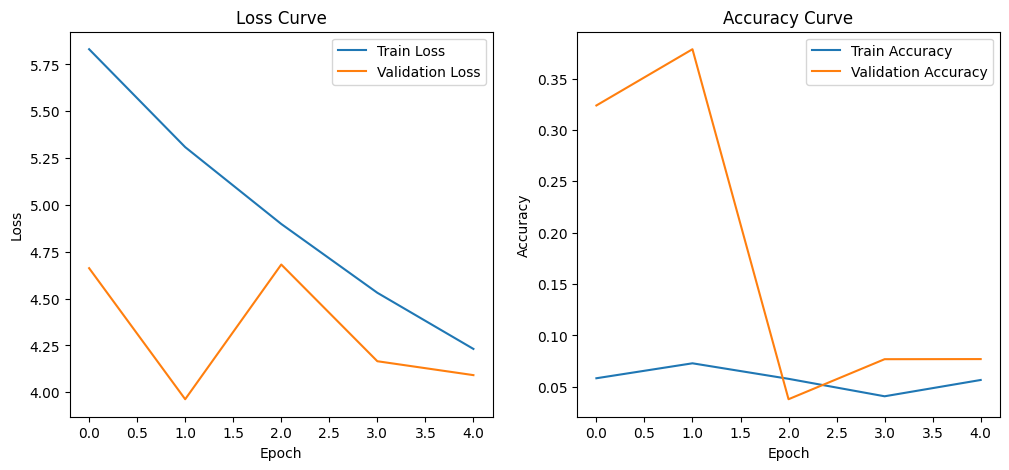

In [ ]:
# Cell 12: Vẽ các đường cong Loss và Accuracy

import matplotlib.pyplot as plt

# Vẽ Loss Curve
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Vẽ Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()